# 07 PyTorch Experiment Tracking

Pembelajaran Mesin adalah seebuah hal yang sangat expiremental

Unttuk menemukan eksperimen mana yang layak untuk dikejar, disitulah **epxeriment tracking** diperlukan.


In [2]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary
from going_modular import data_setup, engine

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

d:\UNSRI_DATA\MACHINE LEARNING\pytorch_course\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.6.0+cu118
0.21.0+cu118


### Helper Function


In [3]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [4]:
set_seeds()

In [5]:
# Siapkan device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Ambil data

Ingin mengambil pizza, steak, sushi

Kita akan menjalankan eksperimen FoodVision Mini dan melihat model mana yang mantap!


In [6]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source:str,
                  destination: str,
                  remove_source: bool = True) -> Path:
  """Mengunduh dataset yang di zip, dan mengunzip sesuai destinasi"""

  #Setup path ke data folder
  data_path = Path("data/")
  image_path = data_path / destination

  # Jika folder gambar tidak ada, buat
  if image_path.is_dir():
    print(f"{image_path} sudah ada")
  else:
    print(f"Membuat {image_path}")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download data target
    target_file = Path(source).name
    with open(data_path / target_file, "wb") as f:
      response = requests.get(source)
      print(f"Downloading {target_file} from {source}...")
      f.write(response.content)

    # Unzip target file
    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
      print(f"Unzipping {target_file} data...")
      zip_ref.extractall(image_path)

    if remove_source:
      os.remove(data_path/target_file)

  return image_path

In [7]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

data\pizza_steak_sushi sudah ada


WindowsPath('data/pizza_steak_sushi')

## 2. Buat datasets dan Dataloaders


### 2.1 Buat DataLoaders dengan manual transforms

Tujuan dengan transform adalah memastikan data kustom kita di format dengan bentuk yang sesuai dengan model pretrained kita


In [8]:
# Buat direktori

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [9]:
# Buat ImageNet normalisasi levels

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Buat pipeline transform manual
from torchvision import transforms
manual_transforms = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  normalize
])
print(f"Membuat transforms secara manual: {manual_transforms}")

Membuat transforms secara manual: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [10]:
# Buat DataLoaders

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1fb598aa2d0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Buat DataLoaders dengan transform otomatis

Prinsip yang sama diterapkan denggan transform otomatis, dimana kita ingin data kustom kita memliki format yang sama dengan yang dibutuhkan oleh pretrained moodel kita


In [11]:
# Buat direktori
train_dir = image_path / "train"
test_dir = image_path / "test"

# Siapkan pretrained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Ambil transfrom dari weights nya
automatic_transforms = weights.transforms()
print(f"Membuat transforms secara otomatis: {automatic_transforms}")

# Buat DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=automatic_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

Membuat transforms secara otomatis: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x1fb598c26d0>,
 ['pizza', 'steak', 'sushi'])

## 3. Buatkan pretrained model, bekukan base layer, dan ubah classifier head nya


In [12]:
# Note: Ini adalah bagaiman pretrained model akan dibuat dengan torchvision v0.12

# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # Cara lama

model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [13]:
# Bekukan semua layyer base, dengan menyetting requres_grad ke false
for param in model.features.parameters():
  param.requires_grad = False

In [14]:
# Siapkan perubahan classifeier head
model.classifier = nn.Sequential(
  nn.Dropout(p=0.2, inplace=True),
  nn.Linear(in_features=1280, 
            out_features=len(class_names),
            bias=True).to(device)
)

In [15]:
from torchinfo import summary

summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### 4. latih single model dan pelajari hasilnya


In [16]:
# Define loss function optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)

### Siapkan TensorBoard untuk Tracking Model


In [17]:
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print("[INFO] Couldn't find tensorboard... installing it.")
    %pip install -q tensorboard

In [18]:
# Siapkan SummaryWriter
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

In [19]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.engine import train_step, test_step

In [20]:
import torch.utils.tensorboard


def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        ### Baru: Experiment Tracking
        writer.add_scalar(tag="Train Loss",
                          scalar_value=train_loss,
                          global_step=epoch)
        writer.add_scalar(tag="Test Loss",
                          scalar_value=test_loss,
                          global_step=epoch)
        

        writer.add_scalar(tag="Train Accuracy",
                          scalar_value=train_acc,
                          global_step=epoch)
        writer.add_scalar(tag="Test Accuracy",
                          scalar_value=test_acc,
                          global_step=epoch)
        
        
        
        writer.add_graph(model=model,
                         input_to_model=torch.randn(32,3,224,224).to(device))
        
    # Tutup writerna
    writer.close()

    # Return the filled results at the end of the epochs
    return results


In [21]:
# Train model
# Note: tidak menggunakan engine.train() karena kita mengupdate train() dengan fungsi diatas

set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0705 | train_acc: 0.4453 | test_loss: 0.8640 | test_acc: 0.7737


 20%|██        | 1/5 [00:10<00:41, 10.36s/it]

Epoch: 2 | train_loss: 0.8889 | train_acc: 0.6641 | test_loss: 0.7685 | test_acc: 0.7841


 40%|████      | 2/5 [00:19<00:28,  9.52s/it]

Epoch: 3 | train_loss: 0.7497 | train_acc: 0.7383 | test_loss: 0.6501 | test_acc: 0.8759


 60%|██████    | 3/5 [00:28<00:18,  9.38s/it]

Epoch: 4 | train_loss: 0.6606 | train_acc: 0.8906 | test_loss: 0.6424 | test_acc: 0.8456


 80%|████████  | 4/5 [00:37<00:09,  9.25s/it]

Epoch: 5 | train_loss: 0.6837 | train_acc: 0.7500 | test_loss: 0.6687 | test_acc: 0.7945


100%|██████████| 5/5 [00:46<00:00,  9.30s/it]


In [22]:
results

{'train_loss': [1.0705370157957077,
  0.8888938054442406,
  0.74970743060112,
  0.6606296971440315,
  0.6836889274418354],
 'train_acc': [0.4453125, 0.6640625, 0.73828125, 0.890625, 0.75],
 'test_loss': [0.8639580210049947,
  0.7685186465581259,
  0.65010533730189,
  0.6424237688382467,
  0.6687165300051371],
 'test_acc': [0.7736742424242425,
  0.7840909090909092,
  0.8759469696969697,
  0.8456439393939394,
  0.7945075757575758]}

## 5. Melihat hasil model kita dengan TensorBoard


In [23]:
# %load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 30556), started 23:06:10 ago. (Use '!kill 30556' to kill it.)

## 6. Buat fungsi untuk menyiapkan `SummaryWriter()`

Secara default `SummaryWriter()` disimpan didalam `log_dir`

Bagaimana jika kita menginginkan untuk menyimpan eksperimen kedalam foolder beda?

Dalam esensinya, satu eksperimen didalam satu folder

Sebagai contoh kita ingin track

- Waktu eksperimen
- Nama eksperimen
- Nama Model
- dan lainnya

Idealnya kita berakhir untuk mentracking eksperimen ke direktori
`runs/YYYY-MM-DD/nama-eksperimen/nama-model/extra`


In [24]:
from datetime import datetime

In [25]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None):
  """Membuat torch.utils.tensorboard.writer.SummaryWriter() untuk mentracking eksperimen kita"""
  from datetime import datetime
  import os 

  # Ambil timestramp dari tanggal sekarang dengan urutan terbalik
  timestamp = datetime.now().strftime("%Y-%m-%d")

  if extra:
    # Buat log direktory path
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
  else:
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

  print(f"[INFO] Membuat SummaryWriter menyimpan ke {log_dir}")
  return SummaryWriter(log_dir=log_dir)

In [26]:
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")
example_writer

[INFO] Membuat SummaryWriter menyimpan ke runs\2025-03-05\data_10_percent\effnetb0\5_epochs


In [27]:
# Update train() untuk menggunakan create_writer()...

import torch.utils.tensorboard


def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        if writer: 
          ### Baru: Experiment Tracking
          writer.add_scalar(tag="Train Loss",
                            scalar_value=train_loss,
                            global_step=epoch)
          writer.add_scalar(tag="Test Loss",
                            scalar_value=test_loss,
                            global_step=epoch)
          

          writer.add_scalar(tag="Train Accuracy",
                            scalar_value=train_acc,
                            global_step=epoch)
          writer.add_scalar(tag="Test Accuracy",
                            scalar_value=test_acc,
                            global_step=epoch)
        
        
        
          writer.add_graph(model=model,
                          input_to_model=torch.randn(32,3,224,224).to(device))
        
          # Tutup writerna
          writer.close()

        else:
           pass

    # Return the filled results at the end of the epochs
    return results

## 7. Siapkan berbagai rangkaian eksperimen model

- Setup 2x modelling experiment with effnetb0, pizza_steak_sushi data, latih satu model dengan 5 epcohs dan yang lain dengan 10 epochs


### 7.1 Jenis eksperimen apa yang harus dijalankan

Jumlah dari eksperimen pembalajran yang dapat kita lakukan adalah jumlah dari model berbeda yang bisa kitta buat.

Apa yang harus kita test?

- Ubah epochs
- Ubah hidden layer
- Ubah jumlah data
- Ubah learning rate
- Coba berbagai macam data augmentasi
- Pilih arsitektur model


### 7.2 Eksperimen apa yang akan kita jalankan

Kita akan melakukan 3 dials:

1. Besaran model - Effnetb0 vs Effnetb2
2. Besaran dataset - 10% data vs 20% data
3. Waktu training - 5 epochs vs 10 epochs


### 7.3 Unduh dataset berbeda

Kita butuh 2 datasets

1. Pizza, steak, sushi - 10%
2. Pizza, steak, sushi - 20%


In [28]:
# unduh data 10 persen dan 20 persen

data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi_20_percent")


data\pizza_steak_sushi sudah ada
data\pizza_steak_sushi_20_percent sudah ada


### 7.4 Transform Dataset and buat Dataloader

Kita akan mengtransfrom data kita menjadi beberapa:

1. resize gambar ke (224,224)
2. Ubah menjadi tensor
3. Normalize


In [29]:
# Siapkan training directory paths
train_dir_10_percent  = data_10_percent_path / "train"
train_dir_20_percent  = data_20_percent_path / "train"

test_dir = data_10_percent_path / "test"

train_dir_10_percent, train_dir_20_percent, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [30]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [31]:
BATCH_SIZE = 32

# Buat 10% training dan test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

# Buat 20% training dan test DataLoaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

### 7.5 Buat fitur model ekstraksi

Kita membutuhkan 2 fungsi

1. Membuat `torchvision.model.efficientnet_b0()` feature ektrasi dengan frozen backbone layer dan custom classifier
2. Membuat `torchvision.model.efficientnet_b2()` feature ektrasi dengan frozen backbone layer dan custom classifier


In [33]:
import torchvision

# Buat EffNetB2
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

effnetb2

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:08<00:00, 4.18MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [34]:
from torchinfo import summary

summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [41]:
import torchvision 
from torch import nn 

OUT_FEATURES = len(class_names)

# Buat EffNetB0 feature extractor
def create_effnetb0():
  # Ambil weight dan setup mode
  weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
  model = torchvision.models.efficientnet_b0(weights=weights).to(device)

  # Freeze basse model layyer
  for param in model.features.parameters():
    param.requires_grad = False 

  # Ubah classifier head
  set_seeds()
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=OUT_FEATURES)
  ).to(device)

  # Berikan nama model
  model.name = "effnetb0"
  print(f"[INFO] Membuat model {model.name} baru...")
  return model



# Buat EffNetB2 feature extractor
def create_effnetb2():
  # Ambil weight dan setup mode
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  model = torchvision.models.efficientnet_b2(weights=weights).to(device)

  # Freeze basse model layyer
  for param in model.features.parameters():
    param.requires_grad = False 

  # Ubah classifier head
  set_seeds()
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=OUT_FEATURES)
  ).to(device)

  # Berikan nama model
  model.name = "effnetb2"
  print(f"[INFO] Membuat model {model.name} baru...")
  return model

In [43]:
created_model_test_effnetb0 = create_effnetb0()
created_model_test_effnetb2 = create_effnetb2()

[INFO] Membuat model effnetb0 baru...
[INFO] Membuat model effnetb2 baru...


### 7.6 Mari buat eksperimen dan siapkan kode training


In [48]:
# Buat epoch list
num_epochs = [5, 10]

# Buat list model
models = ["effnetb0", "effnetb2"]

# Buat DataLoaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                    "data_20_percent": train_dataloader_20_percent}

In [50]:
%%time 
from going_modular.utils import save_model

# Atur seeds
set_seeds()

# Buat track dari nomor eksperimen
experiment_number = 0

# Loop setiap DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
  # Loop setiap epochs
  for epochs in num_epochs:
    # Loop dari setiap nama model
    for model_name in models:
      # Cetak info
      experiment_number += 1

      print(f"[INFO] Nomor eksperimen: {experiment_number}")
      print(f"[INFO] Model: {model_name}")
      print(f"[INFO] DataLoader: {dataloader_name}")
      print(f"[INFO] Jumlah epochs: {epochs}")

      # Pilih dan buat model
      if model_name == "effnetb0":
        model = create_effnetb0()
      else:
        model = create_effnetb2()

      # Buat loss dan optimizer baru
      loss_fn = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(params=model.parameters(),
      lr=0.001)

      # Latih target model dengan target dataloader
      train(model=model,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=epochs,
      device=device,
      writer=create_writer(experiment_name=dataloader_name,
      model_name=model_name,
      extra=f"{epochs}_epochs")
      )


      # Simpan model ke file
      save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
      save_model(model=model,
      target_dir="models",
      model_name=save_filepath)
      print("-"*50 + "\n")

[INFO] Nomor eksperimen: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Jumlah epochs: 5
[INFO] Membuat model effnetb0 baru...
[INFO] Membuat SummaryWriter menyimpan ke runs\2025-03-05\data_10_percent\effnetb0\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0426 | train_acc: 0.5039 | test_loss: 0.9255 | test_acc: 0.4678


 20%|██        | 1/5 [00:09<00:36,  9.09s/it]

Epoch: 2 | train_loss: 0.9400 | train_acc: 0.5352 | test_loss: 0.8308 | test_acc: 0.5492


 40%|████      | 2/5 [00:17<00:26,  8.92s/it]

Epoch: 3 | train_loss: 0.8170 | train_acc: 0.7070 | test_loss: 0.7256 | test_acc: 0.8352


 60%|██████    | 3/5 [00:26<00:17,  8.95s/it]

Epoch: 4 | train_loss: 0.7087 | train_acc: 0.7656 | test_loss: 0.6175 | test_acc: 0.8759


 80%|████████  | 4/5 [00:35<00:08,  8.69s/it]

Epoch: 5 | train_loss: 0.6154 | train_acc: 0.8945 | test_loss: 0.5825 | test_acc: 0.8864


100%|██████████| 5/5 [00:44<00:00,  8.88s/it]


[INFO] Saving model to: models\07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Nomor eksperimen: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Jumlah epochs: 5
[INFO] Membuat model effnetb2 baru...
[INFO] Membuat SummaryWriter menyimpan ke runs\2025-03-05\data_10_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0972 | train_acc: 0.3672 | test_loss: 0.9579 | test_acc: 0.7008


 20%|██        | 1/5 [00:13<00:53, 13.26s/it]

Epoch: 2 | train_loss: 0.8999 | train_acc: 0.6445 | test_loss: 0.9050 | test_acc: 0.6818


 40%|████      | 2/5 [00:26<00:40, 13.36s/it]

Epoch: 3 | train_loss: 0.8454 | train_acc: 0.6719 | test_loss: 0.8107 | test_acc: 0.7841


 60%|██████    | 3/5 [00:39<00:25, 13.00s/it]

Epoch: 4 | train_loss: 0.7073 | train_acc: 0.8398 | test_loss: 0.6982 | test_acc: 0.8864


 80%|████████  | 4/5 [00:52<00:13, 13.13s/it]

Epoch: 5 | train_loss: 0.7073 | train_acc: 0.7305 | test_loss: 0.6559 | test_acc: 0.8864


100%|██████████| 5/5 [01:06<00:00, 13.21s/it]


[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Nomor eksperimen: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Jumlah epochs: 10
[INFO] Membuat model effnetb0 baru...
[INFO] Membuat SummaryWriter menyimpan ke runs\2025-03-05\data_10_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0426 | train_acc: 0.5039 | test_loss: 0.9255 | test_acc: 0.4678


 10%|█         | 1/10 [00:08<01:19,  8.80s/it]

Epoch: 2 | train_loss: 0.9400 | train_acc: 0.5352 | test_loss: 0.8308 | test_acc: 0.5492


 20%|██        | 2/10 [00:17<01:10,  8.85s/it]

Epoch: 3 | train_loss: 0.8170 | train_acc: 0.7070 | test_loss: 0.7256 | test_acc: 0.8352


 30%|███       | 3/10 [00:26<01:01,  8.81s/it]

Epoch: 4 | train_loss: 0.7087 | train_acc: 0.7656 | test_loss: 0.6175 | test_acc: 0.8759


 40%|████      | 4/10 [00:35<00:53,  8.89s/it]

Epoch: 5 | train_loss: 0.6154 | train_acc: 0.8945 | test_loss: 0.5825 | test_acc: 0.8864


 50%|█████     | 5/10 [00:44<00:44,  8.98s/it]

Epoch: 6 | train_loss: 0.5428 | train_acc: 0.8672 | test_loss: 0.5948 | test_acc: 0.8561


 60%|██████    | 6/10 [00:54<00:36,  9.13s/it]

Epoch: 7 | train_loss: 0.6414 | train_acc: 0.7227 | test_loss: 0.5922 | test_acc: 0.8153


 70%|███████   | 7/10 [01:03<00:27,  9.20s/it]

Epoch: 8 | train_loss: 0.5093 | train_acc: 0.8047 | test_loss: 0.5356 | test_acc: 0.8968


 80%|████████  | 8/10 [01:12<00:18,  9.14s/it]

Epoch: 9 | train_loss: 0.4680 | train_acc: 0.9180 | test_loss: 0.5289 | test_acc: 0.8759


 90%|█████████ | 9/10 [01:21<00:09,  9.16s/it]

Epoch: 10 | train_loss: 0.5726 | train_acc: 0.7461 | test_loss: 0.4855 | test_acc: 0.8759


100%|██████████| 10/10 [01:30<00:00,  9.06s/it]


[INFO] Saving model to: models\07_effnetb0_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Nomor eksperimen: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Jumlah epochs: 10
[INFO] Membuat model effnetb2 baru...
[INFO] Membuat SummaryWriter menyimpan ke runs\2025-03-05\data_10_percent\effnetb2\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0972 | train_acc: 0.3672 | test_loss: 0.9579 | test_acc: 0.7008


 10%|█         | 1/10 [00:12<01:56, 12.90s/it]

Epoch: 2 | train_loss: 0.8999 | train_acc: 0.6445 | test_loss: 0.9050 | test_acc: 0.6818


 20%|██        | 2/10 [00:26<01:45, 13.13s/it]

Epoch: 3 | train_loss: 0.8454 | train_acc: 0.6719 | test_loss: 0.8107 | test_acc: 0.7841


 30%|███       | 3/10 [00:39<01:32, 13.21s/it]

Epoch: 4 | train_loss: 0.7073 | train_acc: 0.8398 | test_loss: 0.6982 | test_acc: 0.8864


 40%|████      | 4/10 [00:52<01:17, 12.95s/it]

Epoch: 5 | train_loss: 0.7073 | train_acc: 0.7305 | test_loss: 0.6559 | test_acc: 0.8864


 50%|█████     | 5/10 [01:05<01:05, 13.03s/it]

Epoch: 6 | train_loss: 0.5943 | train_acc: 0.8906 | test_loss: 0.6652 | test_acc: 0.8665


 60%|██████    | 6/10 [01:18<00:53, 13.25s/it]

Epoch: 7 | train_loss: 0.6120 | train_acc: 0.8086 | test_loss: 0.6097 | test_acc: 0.9280


 70%|███████   | 7/10 [01:31<00:39, 13.11s/it]

Epoch: 8 | train_loss: 0.5408 | train_acc: 0.8125 | test_loss: 0.6047 | test_acc: 0.8873


 80%|████████  | 8/10 [01:44<00:25, 12.91s/it]

Epoch: 9 | train_loss: 0.4981 | train_acc: 0.9023 | test_loss: 0.5607 | test_acc: 0.8674


 90%|█████████ | 9/10 [01:57<00:12, 12.97s/it]

Epoch: 10 | train_loss: 0.5230 | train_acc: 0.7969 | test_loss: 0.5463 | test_acc: 0.8977


100%|██████████| 10/10 [02:10<00:00, 13.01s/it]


[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Nomor eksperimen: 5
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Jumlah epochs: 5
[INFO] Membuat model effnetb0 baru...
[INFO] Membuat SummaryWriter menyimpan ke runs\2025-03-05\data_20_percent\effnetb0\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9664 | train_acc: 0.6271 | test_loss: 0.6670 | test_acc: 0.8759


 20%|██        | 1/5 [00:13<00:54, 13.61s/it]

Epoch: 2 | train_loss: 0.6942 | train_acc: 0.7937 | test_loss: 0.5802 | test_acc: 0.9072


 40%|████      | 2/5 [00:27<00:40, 13.55s/it]

Epoch: 3 | train_loss: 0.5809 | train_acc: 0.8313 | test_loss: 0.5030 | test_acc: 0.8977


 60%|██████    | 3/5 [00:39<00:26, 13.08s/it]

Epoch: 4 | train_loss: 0.4568 | train_acc: 0.8875 | test_loss: 0.4160 | test_acc: 0.9072


 80%|████████  | 4/5 [00:52<00:12, 12.98s/it]

Epoch: 5 | train_loss: 0.4532 | train_acc: 0.8562 | test_loss: 0.3809 | test_acc: 0.9280


100%|██████████| 5/5 [01:05<00:00, 13.14s/it]


[INFO] Saving model to: models\07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Nomor eksperimen: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Jumlah epochs: 5
[INFO] Membuat model effnetb2 baru...
[INFO] Membuat SummaryWriter menyimpan ke runs\2025-03-05\data_20_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9848 | train_acc: 0.5271 | test_loss: 0.7862 | test_acc: 0.8049


 20%|██        | 1/5 [00:19<01:16, 19.02s/it]

Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8167 | test_loss: 0.6548 | test_acc: 0.8968


 40%|████      | 2/5 [00:37<00:55, 18.67s/it]

Epoch: 3 | train_loss: 0.5802 | train_acc: 0.8979 | test_loss: 0.5562 | test_acc: 0.9384


 60%|██████    | 3/5 [00:56<00:37, 18.89s/it]

Epoch: 4 | train_loss: 0.5242 | train_acc: 0.8521 | test_loss: 0.5146 | test_acc: 0.9384


 80%|████████  | 4/5 [01:15<00:18, 18.73s/it]

Epoch: 5 | train_loss: 0.4710 | train_acc: 0.8604 | test_loss: 0.4479 | test_acc: 0.9489


100%|██████████| 5/5 [01:34<00:00, 18.95s/it]


[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Nomor eksperimen: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Jumlah epochs: 10
[INFO] Membuat model effnetb0 baru...
[INFO] Membuat SummaryWriter menyimpan ke runs\2025-03-05\data_20_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9664 | train_acc: 0.6271 | test_loss: 0.6670 | test_acc: 0.8759


 10%|█         | 1/10 [00:13<02:01, 13.54s/it]

Epoch: 2 | train_loss: 0.6942 | train_acc: 0.7937 | test_loss: 0.5802 | test_acc: 0.9072


 20%|██        | 2/10 [00:26<01:46, 13.30s/it]

Epoch: 3 | train_loss: 0.5809 | train_acc: 0.8313 | test_loss: 0.5030 | test_acc: 0.8977


 30%|███       | 3/10 [00:40<01:34, 13.45s/it]

Epoch: 4 | train_loss: 0.4568 | train_acc: 0.8875 | test_loss: 0.4160 | test_acc: 0.9072


 40%|████      | 4/10 [00:52<01:18, 13.15s/it]

Epoch: 5 | train_loss: 0.4532 | train_acc: 0.8562 | test_loss: 0.3809 | test_acc: 0.9280


 50%|█████     | 5/10 [01:06<01:05, 13.10s/it]

Epoch: 6 | train_loss: 0.4179 | train_acc: 0.8562 | test_loss: 0.3730 | test_acc: 0.9280


 60%|██████    | 6/10 [01:18<00:52, 13.04s/it]

Epoch: 7 | train_loss: 0.4012 | train_acc: 0.8625 | test_loss: 0.3374 | test_acc: 0.9176


 70%|███████   | 7/10 [01:31<00:38, 12.89s/it]

Epoch: 8 | train_loss: 0.3426 | train_acc: 0.8958 | test_loss: 0.3475 | test_acc: 0.9384


 80%|████████  | 8/10 [01:44<00:25, 12.97s/it]

Epoch: 9 | train_loss: 0.3693 | train_acc: 0.8938 | test_loss: 0.3430 | test_acc: 0.9384


 90%|█████████ | 9/10 [01:57<00:12, 12.98s/it]

Epoch: 10 | train_loss: 0.3769 | train_acc: 0.8958 | test_loss: 0.2837 | test_acc: 0.9176


100%|██████████| 10/10 [02:11<00:00, 13.11s/it]


[INFO] Saving model to: models\07_effnetb0_data_20_percent_10_epochs.pth
--------------------------------------------------

[INFO] Nomor eksperimen: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Jumlah epochs: 10
[INFO] Membuat model effnetb2 baru...
[INFO] Membuat SummaryWriter menyimpan ke runs\2025-03-05\data_20_percent\effnetb2\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9848 | train_acc: 0.5271 | test_loss: 0.7862 | test_acc: 0.8049


 10%|█         | 1/10 [00:20<03:08, 20.98s/it]

Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8167 | test_loss: 0.6548 | test_acc: 0.8968


 20%|██        | 2/10 [00:38<02:31, 18.92s/it]

Epoch: 3 | train_loss: 0.5802 | train_acc: 0.8979 | test_loss: 0.5562 | test_acc: 0.9384


 30%|███       | 3/10 [00:55<02:05, 17.88s/it]

Epoch: 4 | train_loss: 0.5242 | train_acc: 0.8521 | test_loss: 0.5146 | test_acc: 0.9384


 40%|████      | 4/10 [01:11<01:42, 17.12s/it]

Epoch: 5 | train_loss: 0.4710 | train_acc: 0.8604 | test_loss: 0.4479 | test_acc: 0.9489


 50%|█████     | 5/10 [01:27<01:24, 16.92s/it]

Epoch: 6 | train_loss: 0.3819 | train_acc: 0.9062 | test_loss: 0.4580 | test_acc: 0.9280


 60%|██████    | 6/10 [01:44<01:08, 17.05s/it]

Epoch: 7 | train_loss: 0.3615 | train_acc: 0.8979 | test_loss: 0.4200 | test_acc: 0.9280


 70%|███████   | 7/10 [02:01<00:51, 17.01s/it]

Epoch: 8 | train_loss: 0.3369 | train_acc: 0.8958 | test_loss: 0.4170 | test_acc: 0.9280


 80%|████████  | 8/10 [02:19<00:34, 17.26s/it]

Epoch: 9 | train_loss: 0.3545 | train_acc: 0.8938 | test_loss: 0.4391 | test_acc: 0.8371


 90%|█████████ | 9/10 [02:36<00:17, 17.25s/it]

Epoch: 10 | train_loss: 0.3678 | train_acc: 0.8688 | test_loss: 0.3745 | test_acc: 0.9489


100%|██████████| 10/10 [02:53<00:00, 17.31s/it]

[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
--------------------------------------------------

CPU times: total: 13min 28s
Wall time: 13min 24s


## 8. Lihat eksperimen di TensorBoard

In [52]:
# %load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 30556), started 23:48:26 ago. (Use '!kill 30556' to kill it.)

Model dengan performa terbaik adalah:
* Model: EffNetB2
* Dataset: Pizza, steak, sushi, 20%
* Epochs: 10

Dan hasilnya adalah, lebih banyak data, lebih besar model, dan lebih lama waktu trainnya, menuntuk kepada hasil yang lebih ciamik polo!

## 9. Load the best model

In [56]:
# Setup best model filepath
best_model_path = r"D:\UNSRI_DATA\MACHINE LEARNING\pytorch_course\07_pytorch_experiment_tracking\models\07_effnetb0_data_20_percent_10_epochs.pth"

best_model = create_effnetb0()

# Muat best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Membuat model effnetb0 baru...


<All keys matched successfully>

In [57]:
# Check the model file size
from pathlib import Path 

# Ambil besar nya model dalam bytes lalu convery ke megabytes
effnetb0_model_size = Path(best_model_path).stat().st_size // (1024*1024)

print(f"EfficientNetB0 feature extracotr model size: {effnetb0_model_size} MB")

EfficientNetB0 feature extracotr model size: 15 MB


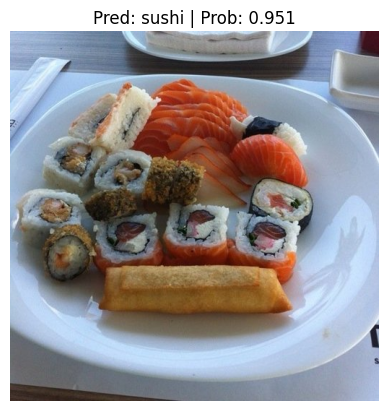

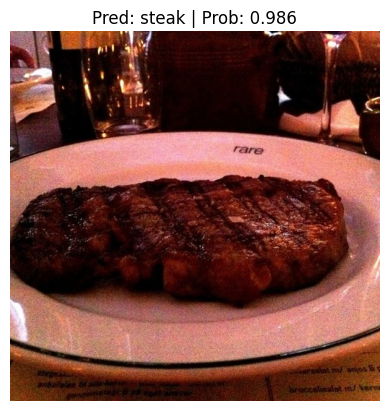

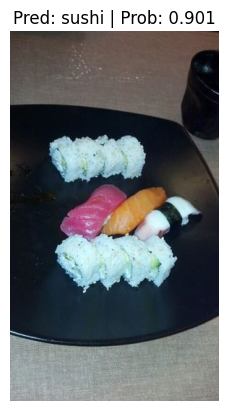

In [63]:
# Import fungsi untuk membaut prediksi dan plot mereka
from going_modular.predictions import pred_and_plot_image

# Ambil random list dari 3 path gambar
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list,
                                      k=num_images_to_plot)

for image_path in test_image_path_sample:
  pred_and_plot_image(model=best_model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224,224))